In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy as sp
import inspect
import os
import sys
import time

import paragami

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [3]:
reg_params = dict()
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes10000.npz'
#datafile = 'fits/transformed_gene_regression_df7_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df$_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df7_degree3_genes1000.npz'
#datafile = 'fits/shrunken_transformed_gene_regression_df4_degree3_genes1000.npz'
datafile = 'fits/shrunken_transformed_gene_regression_df4_degree3_genes10000_inflate1.0.npz'
with np.load(datafile) as infile:
    reg_params['y_info'] = infile['y_info']
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    df = infile['df']
    degree = infile['degree']
    inflate_cov = infile.get('inflate_cov', 0)
    eb_shrunk = infile.get('eb_shrunk', False)

    
num_genes = reg_params['beta_mean'].shape[0]
obs_dim = reg_params['beta_mean'].shape[1]

num_components = 30

analysis_name = 'transformed_gene_regression_df{}_degree{}_genes{}_num_components{}_inflate{}_shrunk{}_fit'.format(
    df, degree, num_genes, num_components, inflate_cov, eb_shrunk)

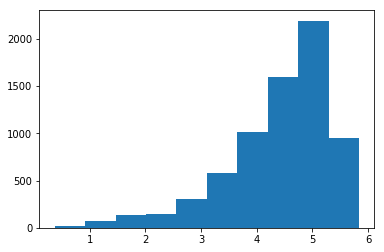

In [4]:
plt.hist(reg_params['y_info']);

In [5]:
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
prior_params_pattern = gmm_lib.get_prior_params_pattern(obs_dim, num_components)
prior_params_pattern.validate_folded(prior_params)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [6]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [7]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -9771.93336572
Iter 1: f = -11582.98031802
Iter 2: f = -12842.92478833
Iter 3: f = -13263.03050043
Iter 4: f = -14040.17544166
Iter 5: f = -14169.00802690
Iter 6: f = -14372.24629362
Iter 7: f = -14492.49317132
Iter 8: f = -13813.80921408
Iter 9: f = -14572.49129599
Iter 10: f = -14607.09693438
Iter 11: f = -14659.80851057
Iter 12: f = -14678.31568940
Iter 13: f = -14711.94805854
Iter 14: f = -14721.06450698
Iter 15: f = -14741.34980895
Iter 16: f = -14749.09903120
Iter 17: f = -14761.70638924
Iter 18: f = -14763.38012493
Iter 19: f = -14764.53064700
Iter 20: f = -14766.68760962
Iter 21: f = -14770.47472397
Iter 22: f = -14772.54305632
Iter 23: f = -14772.05320138
Iter 24: f = -14774.33675313
Iter 25: f = -14777.01199241
Iter 26: f = -14779.44018771
Iter 27: f = -14782.88245369
Iter 28: f = -14783.89964178
Iter 29: f = -14785.91593587
Iter 30: f = -14779.02648140
Iter 31: f = -14788.89597834
Iter 32: f = -14788.96700493
Iter 33: f = -14791.72332095
Iter 34: f = -14773.33348

In [8]:
tic = time.time()
# Note that h_cond is the Hessian.
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [9]:
h_cond.shape, gmm.kl_obj.grad(init_x2).shape

((238, 238), (238,))

In [10]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True, kl_hess=h_cond)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Iter 0: f = -14817.08398249
Preconditioned iteration 1
  Taking Newton step.
Iter 1: f = -14817.08398249
Iter 2: f = -14817.08402428
4.1791996409301646e-05
Iter 3: f = -14817.08402428
Success.
  Running preconditioned optimization.
Iter 0: f = -14817.08402428
Iter 1: f = -14817.08402481
Iter 2: f = -14817.08402481
Iter 4: f = -14817.08402481
f_diff: 4.2315044993301854e-05
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Taking Newton step.
  Converging with small Newton step.
Optimization time: 2369.6836619377136 seconds


In [11]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.sort(np.sum(e_z, axis=0)))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[3.39981297e-01 7.06165787e-01 9.10091898e-01 1.45438093e+00
 1.56223873e+00 1.88441407e+00 1.96389252e+00 1.96556340e+00
 2.73233052e+00 2.86549068e+00 2.91966221e+00 3.01571613e+00
 3.30017610e+00 6.37191962e+00 6.53708990e+00 8.33692925e+00
 1.17952989e+01 1.51472568e+01 2.43529261e+01 3.04389883e+01
 3.06484121e+01 3.63680154e+01 5.58889158e+01 8.05994291e+01
 1.62773207e+02 2.25442362e+02 2.59538668e+02 4.14120992e+02
 2.40390154e+03 3.20211794e+03]


In [12]:
loglik_obs_by_nk = gmm_lib.get_loglik_obs_by_nk(opt_gmm_params, gmm.reg_params)

In [17]:
# for i in range(num_components):
#     print('{:0.5}\t{:0.5}'.format(np.sum(e_z, axis=0)[i], np.std(e_z, axis=0)[i]))

small_cluster_size = 1.1

z_sum = np.sum(e_z, axis=0)
small_clusters = np.squeeze(np.argwhere(z_sum < small_cluster_size))
small_clusters
obs_k = np.full(gmm.num_obs, int(-1))
for n in range(gmm.num_obs):
    obs_k[n] = np.argmax(e_z[n, :])

# Plot one of the small components
print('There are', len(small_clusters), 'small clusters')
k_small = 0
n_in_cluster = np.argwhere(obs_k == small_clusters[k_small])

if len(n_in_cluster) > 0:
    n = int(n_in_cluster[0])

    # Get the top alternative components
    top_components = np.argsort(-1 * loglik_obs_by_nk[n, :])[0:5]

    f, axarr = plt.subplots(1, figsize=(15,8))
    this_plot = axarr
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(60): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))
        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.04, linewidth=4);

    for k in top_components:
        if k != k_small:
            this_plot.plot(opt_gmm_params['centroids'][k, :],
                           color = 'lightblue', linewidth=2);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);
else:
    print('No points belong mostly to this cluster ({}).'.format(small_clusters[k_small]))


There are 3 small clusters
No points belong mostly to this cluster (25).


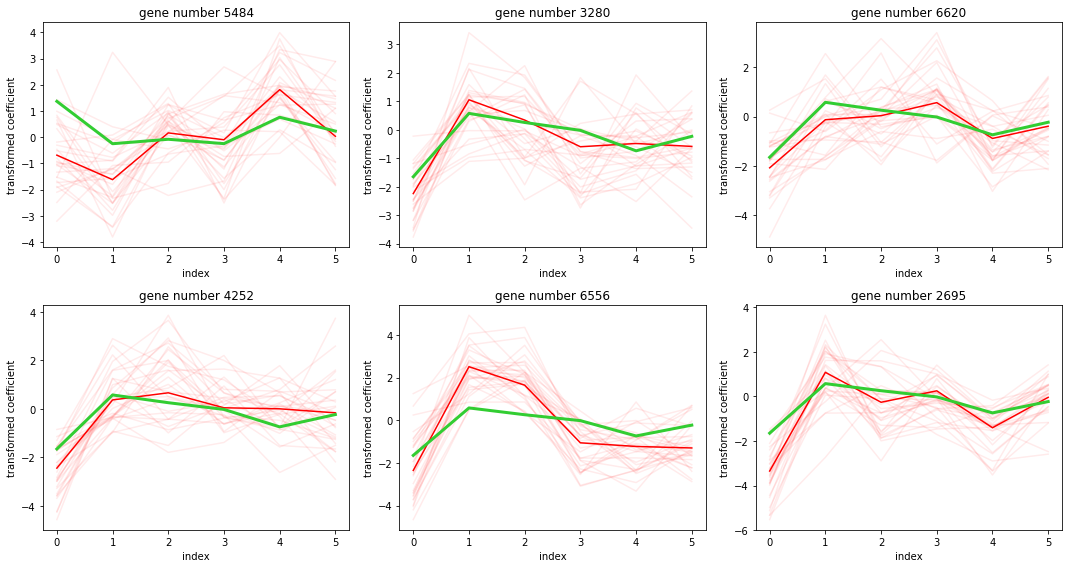

In [18]:
# Sanity check with a figure

f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        this_plot.plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()

In [19]:
save_dict = deepcopy(gmm_opt)
save_dict['df'] = df
save_dict['degree'] = degree
save_dict['datafile'] = datafile
save_dict['num_components'] = num_components
save_dict['gmm_params_pattern_json'] = \
    gmm.gmm_params_pattern.to_json()
save_dict['opt_gmm_params_flat'] = \
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=False)
save_dict['prior_params_pattern_json'] = \
    prior_params_pattern.to_json()
save_dict['prior_params_flat'] = \
    prior_params_pattern.flatten(prior_params, free=False)

save_dict['opt_time'] = opt_time

outfile = './fits/{}.npz'.format(analysis_name)
print('Saving to {}'.format(outfile))

np.savez_compressed(file=outfile, **save_dict)

Saving to ./fits/transformed_gene_regression_df4_degree3_genes7000_num_components30_inflate1.0_shrunkTrue_fit.npz
